In [35]:
import numpy as np
import pandas as pd
import pymap3d
from numpy.linalg import inv
import warnings
warnings.filterwarnings('ignore')

In [36]:
class GNSS_filter:
    def __init__(self, row):
        dt = 5e-2

        self.Nx = 6  # number of states: pos, vel
        self.Nu = 3  # number of input var: vel

        self.X = np.zeros(
            [self.Nx, 1]
        )  # error states: pos_xyz, v_ned, eul, bias_acc, bias_gyro

        # Initial antenna location
        pos_xyz = np.array((row["x"], row["y"], row["z"])).reshape(3, 1)
        self.X[0:3] = pos_xyz
        # Initial antenna velocity
        rot, v_xyz = self.rot_vel(row)

        self.X[3:6] = v_xyz

        # Process model

        # State transition matrix
        self.F = np.identity(self.Nx)

        self.F[0:3, 3:6] = np.identity(3) * dt

        self.P = np.identity(self.Nx)  # Set initial values to 0.25?

        # Process noise matrix
        self.gnss_pos_psd = 3.125e-5
        self.vel_psd = 0.0025

        self.Q = np.zeros([self.Nx, self.Nx])

        self.updateQ(dt)

        # Position measurement noise
        self.R_position = np.identity(3)
        self.R_position[0, 0] = row.sdx**2
        self.R_position[1, 1] = row.sdy**2
        self.R_position[2, 2] = row.sdz**2

        self.R_position[0, 1] = np.sign(row.sdxy) * row.sdxy**2
        self.R_position[0, 2] = np.sign(row.sdxz) * row.sdxz**2
        self.R_position[1, 2] = np.sign(row.sdyz) * row.sdyz**2

        self.R_position[1, 0] = self.R_position[0, 1]
        self.R_position[2, 0] = self.R_position[0, 2]
        self.R_position[2, 1] = self.R_position[1, 2]

        # Velocity measurement noise
        self.R_velocity = np.identity(3) * 4e-8

        self.R_velocity[0, 1] = 1.5e-9
        self.R_velocity[0, 2] = 1.5e-9
        self.R_velocity[1, 2] = 1.5e-9

        self.R_velocity[1, 0] = self.R_velocity[0, 1]
        self.R_velocity[2, 0] = self.R_velocity[0, 2]
        self.R_velocity[2, 1] = self.R_velocity[1, 2]

        if "v_sde" in row:
            self.R_velocity[0, 0] = row.v_sde**2
            self.R_velocity[1, 1] = row.v_sdn**2
            self.R_velocity[2, 2] = row.v_sdu**2

            self.R_velocity[0, 1] = row.v_sden
            self.R_velocity[0, 2] = row.v_sdeu
            self.R_velocity[1, 2] = row.v_sdnu

            self.R_velocity[1, 0] = self.R_velocity[0, 1]
            self.R_velocity[2, 0] = self.R_velocity[0, 2]
            self.R_velocity[2, 1] = self.R_velocity[1, 2]

        self.R_velocity = rot @ self.R_velocity @ rot.transpose()

    def rot_vel(self, row):
        """
        ------------------- Rotate ENU velocity into ECEF velocity --------------------------------
                   dX = |  -sg   -sa*cg  ca*cg | | de |        de = |  -sg       cg      0 | | dX |
                   dY = |   cg   -sa*sg  ca*sg | | dn |  and   dn = |-sa*cg  -sa*sg     ca | | dY |
                   dZ = |    0    ca     sa    | | du |        du = | ca*cg   ca*sg     sa | | dZ |
        -------------------------------------------------------------------------------------------
        """
        v_enu = np.array((row["vel_e"], row["vel_n"], row["vel_u"])).reshape(3, 1)
        lat, lon, alt = pymap3d.ecef2geodetic(self.X[0], self.X[1], self.X[2])
        lat = np.deg2rad(lat)
        lam = np.deg2rad(lon)

        ca = np.cos(lat)
        sa = np.sin(lat)

        cg = np.cos(lam)
        sg = np.sin(lam)

        rot = np.zeros((3, 3))
        rot[0, 0] = -sg
        rot[0, 1] = -sa * cg
        rot[0, 2] = ca * cg
        rot[1, 0] = cg
        rot[1, 1] = -sa * sg
        rot[1, 2] = ca * sg
        rot[2, 0] = 0
        rot[2, 1] = ca
        rot[2, 2] = sa
        v_xyz = rot @ v_enu

        return rot, v_xyz

    def updateQ(self, dt):
        # Position estimation noise
        # Initial Q values from Chadwell code 3.125d-5 3.125d-5 3.125d-5 0.0025 0.0025 0.0025, assumes white noise of 2.5 cm over a second
        self.Q[0:3, 0:3] = np.identity(3) * self.gnss_pos_psd * dt

        # Velocity estimation noise (acc psd)
        self.Q[3:6, 3:6] = np.identity(3) * self.vel_psd

    def predict(self, dt):  # w is the angular rate vector
        self.F[0:3, 3:6] = np.identity(3) * dt

        self.updateQ(dt)

        self.X = self.F @ self.X
        self.P = self.F @ self.P @ self.F.transpose() + self.Q

    def updateVel_cov(self, row):
        rot, v_xyz = self.rot_vel(row)

        self.R_velocity[0, 0] = row.v_sde**2
        self.R_velocity[1, 1] = row.v_sdn**2
        self.R_velocity[2, 2] = row.v_sdu**2

        self.R_velocity[0, 1] = row.v_sden
        self.R_velocity[0, 2] = row.v_sdeu
        self.R_velocity[1, 2] = row.v_sdnu

        self.R_velocity[1, 0] = self.R_velocity[0, 1]
        self.R_velocity[2, 0] = self.R_velocity[0, 2]
        self.R_velocity[2, 1] = self.R_velocity[1, 2]
        self.R_velocity = rot @ self.R_velocity @ rot.transpose()

    def updatePosition(self, row):
        # 		pos_ned = row[['pos_n','pos_e','pos_d']].values.reshape(3,1)
        pos_xyz = np.array((row["x"], row["y"], row["z"])).reshape(3, 1)

        H = np.zeros([3, self.Nx])
        H[0:3, 0:3] = np.identity(3)

        self.R_position[0, 0] = row.sdx**2
        self.R_position[1, 1] = row.sdy**2
        self.R_position[2, 2] = row.sdz**2

        self.R_position[0, 1] = np.sign(row.sdxy) * row.sdxy**2
        self.R_position[0, 2] = np.sign(row.sdxz) * row.sdxz**2
        self.R_position[1, 2] = np.sign(row.sdyz) * row.sdyz**2

        self.R_position[1, 0] = self.R_position[0, 1]
        self.R_position[2, 0] = self.R_position[0, 2]
        self.R_position[2, 1] = self.R_position[1, 2]

        y = pos_xyz - H @ self.X
        S = H @ self.P @ H.transpose() + self.R_position
        K = (self.P @ H.transpose()) @ inv(S)
        self.X = self.X + K @ y

        I = np.identity(self.Nx)
        self.P = (I - K @ H) @ self.P

    def updateVelocity(self, row):
        # 		v_ned = row[['vel_n', 'vel_e', 'vel_d']].values.reshape(3,1)
        rot, v_xyz = self.rot_vel(row)

        H = np.zeros([3, self.Nx])
        H[0:3, 3:6] = np.identity(3)

        y = v_xyz - H @ self.X
        S = H @ self.P @ H.transpose() + self.R_velocity
        K = (self.P @ H.transpose()) @ inv(S)
        self.X = self.X + K @ y

        I = np.identity(self.Nx)
        self.P = (I - K @ H) @ self.P

    def get_states(self):
        return {
            "x": np.ndarray.item(self.X[0]),
            "y": np.ndarray.item(self.X[1]),
            "z": np.ndarray.item(self.X[2]),
            "vx": np.ndarray.item(self.X[3]),
            "vy": np.ndarray.item(self.X[4]),
            "vz": np.ndarray.item(self.X[5]),
        }

    def return_states(self):
        return self.X

    def return_covariance(self):
        return self.P

    def rts_smoother(self, Xs, Ps):
        # Rauch, Tongue, and Striebel smoother

        n, dim_x, _ = Xs.shape

        # smoother gain
        K = np.zeros((n, dim_x, dim_x))
        x, P, Pp = Xs.copy(), Ps.copy(), Ps.copy()

        i = 0
        for k in range(n - 2, -1, -1):
            Pp[k] = self.F @ P[k] @ self.F.T + self.Q  # predicted covariance

            K[k] = P[k] @ self.F.T @ inv(Pp[k])
            x[k] += K[k] @ (x[k + 1] - (self.F @ x[k]))
            P[k] += K[k] @ (P[k + 1] - Pp[k]) @ K[k].T
            i += 1
            print(str(i + 1) + "/" + str(n), end="\r")
        print("")

        return x, P, K, Pp


In [37]:
def run_filter_simulation(df):
    import time

    init = True

    results = []
    Xs = np.zeros([len(df), 6, 1])
    Ps = np.zeros([len(df), 6, 6])

    all_results = pd.DataFrame()

    # Process data through forward Kalman filter
    for i in range(len(df)):
        row = df[i]
        print(str(i + 1) + "/" + str(len(df)), end="\r")

        if init:
            gnss_kf = GNSS_filter(row)
            init = False
            last_time = row.dts
        else:
            dt = abs(
                row.dts - last_time
            )  # This helps to stabilize the solution, abs ensures reverse filtering works.
            gnss_kf.predict(dt)
            last_time = row.dts

            # New velocity standard deviations
            if "v_sde" in row.dtype.names:
                if not np.isnan(row["v_sde"]):
                    gnss_kf.updateVel_cov(row)
            # new GNSS measurement
            if not np.isnan(row["x"]):
                gnss_kf.updatePosition(row)
            # new velocity measurement
            if not np.isnan(row["vel_e"]):
                gnss_kf.updateVelocity(row)

        X = gnss_kf.return_states()
        P = gnss_kf.return_covariance()
        Xs[i] = X
        Ps[i] = P

    print("")
    print("Smoothing results")
    x, P, K, Pp = gnss_kf.rts_smoother(Xs, Ps)

    return x, P, K, Pp


In [38]:
from gnatss.loaders import read_novatel_L1_data_files

In [39]:
inspvaa_df = read_novatel_L1_data_files(data_files=['tests/data/2022/NCL1/NCL1_INSPVAA.dat'], data_format="INSPVAA")

In [40]:
insstdeva_df = read_novatel_L1_data_files(data_files=['tests/data/2022/NCL1/NCL1_INSSTDEVA.dat'], data_format="INSSTDEVA")
 

In [41]:
inspvaa_df = inspvaa_df.rename(
    columns={
        "ant_e": "vel_e",
        "ant_n": "vel_n",
        "ant_u": "vel_u",
        "time":"dts",
    },
    errors="raise"
)
inspvaa_df = inspvaa_df[
    [
        'dts', 'vel_e', 'vel_n', 'vel_u',
    ]
]

In [42]:
insstdeva_df = insstdeva_df.rename(
    columns={
        "ant_e std": "v_sde",
        "ant_n std": "v_sdn",
        "ant_u std": "v_sdu",
        "time":"dts",
    },
    errors="raise"
)
insstdeva_df = insstdeva_df[
    [
        'dts',
        'v_sde', 'v_sdn', 'v_sdu'
    ]
]

insstdeva_df["v_sden"] = 0.0
insstdeva_df["v_sdeu"] = 0.0
insstdeva_df["v_sdnu"] = 0.0


In [43]:
inspvaa_df

,dts,vel_e,vel_n,vel_u
0,7.122935e+08,0.1014,-0.6858,0.2413
1,7.122935e+08,0.0788,-0.6380,0.2734
2,7.122935e+08,0.0534,-0.5833,0.2926
3,7.122935e+08,0.0405,-0.5440,0.2950
4,7.122935e+08,0.0346,-0.5122,0.2801
...,...,...,...,...
3865082,7.123618e+08,1.0631,-0.9726,-0.1158
3865083,7.123618e+08,1.0885,-0.9804,-0.1416
3865084,7.123618e+08,1.1255,-0.9709,-0.1728
3865085,7.123618e+08,1.1578,-0.9542,-0.2087


In [44]:
insstdeva_df

,dts,v_sde,v_sdn,v_sdu,v_sden,v_sdeu,v_sdnu
0,7.122935e+08,0.0159,0.0179,0.0160,0.0,0.0,0.0
1,7.122935e+08,0.0159,0.0179,0.0160,0.0,0.0,0.0
2,7.122935e+08,0.0159,0.0179,0.0160,0.0,0.0,0.0
3,7.122935e+08,0.0159,0.0179,0.0160,0.0,0.0,0.0
4,7.122935e+08,0.0159,0.0179,0.0160,0.0,0.0,0.0
...,...,...,...,...,...,...,...
3865303,7.123618e+08,0.0147,0.0172,0.0206,0.0,0.0,0.0
3865304,7.123618e+08,0.0147,0.0172,0.0206,0.0,0.0,0.0
3865305,7.123618e+08,0.0147,0.0172,0.0206,0.0,0.0,0.0
3865306,7.123618e+08,0.0147,0.0172,0.0206,0.0,0.0,0.0


In [45]:
# ins_data_df = inspvaa_df.merge(insstdeva_df, on="time", how="inner")
# ins_data_df

In [46]:
# vel_std_df = vel_std_df.drop_duplicates(subset="time", keep="first")

In [47]:
# ins_data_df = ins_data_df.rename(
#     columns={
#         "ant_e": "vel_e",
#         "ant_n": "vel_n",
#         "ant_u": "vel_u",
#         "ant_e std": "v_sde",
#         "ant_n std": "v_sdn",
#         "ant_u std": "v_sdu",
#         "time":"dts",
#     },
#     errors="raise"
# )
# ins_data_df = ins_data_df[
#     [
#         'dts', 'vel_e', 'vel_n', 'vel_u',
#         'v_sde', 'v_sdn', 'v_sdu'
#     ]
# ]

In [48]:
# ins_data_df["v_sden"] = 0.0
# ins_data_df["v_sdeu"] = 0.0
# ins_data_df["v_sdnu"] = 0.0
# ins_data_df

In [49]:
"""
def load_gps_solutions(
    files: List[str], time_round: int = constants.DELAY_TIME_PRECISION
) -> pd.DataFrame:
"""
from gnatss.loaders import load_gps_solutions
gps_df = load_gps_solutions(
    files = [
        'tests/data/2022/NCL1/208/GPS_PPP/GPS_POS_FREED',
        'tests/data/2022/NCL1/209/GPS_PPP/GPS_POS_FREED',
        'tests/data/2022/NCL1/210/GPS_PPP/GPS_POS_FREED',

    ],
    columns=["time", "dtype", "x", "y", "z", "sdx", "sdy", "sdz"],
)
gps_df = gps_df.rename(
    columns={
        "time":"dts",
    },
    errors="raise"
)

gps_df = gps_df[
    [
        'dts', 'x', 'y', 'z', 'sdx', 'sdy', 'sdz'
    ]
]

gps_df["sdxy"] = np.sqrt(gps_df.sdx * gps_df.sdy)
gps_df["sdxz"] = np.sqrt(gps_df.sdx * gps_df.sdz)
gps_df["sdyz"] = np.sqrt(gps_df.sdy * gps_df.sdz)

gps_df

,dts,x,y,z,sdx,sdy,sdz,sdxy,sdxz,sdyz
0,712207183.0,-2.574893e+06,-3.681574e+06,4.512097e+06,2.4491,2.4489,2.4488,2.449000,2.448950,2.448850
1,712207184.0,-2.574893e+06,-3.681574e+06,4.512097e+06,2.2359,2.2357,2.2356,2.235800,2.235750,2.235650
2,712207185.0,-2.574893e+06,-3.681574e+06,4.512097e+06,2.0000,1.9998,1.9997,1.999900,1.999850,1.999750
3,712207186.0,-2.574893e+06,-3.681574e+06,4.512097e+06,1.7323,1.7320,1.7319,1.732150,1.732100,1.731950
4,712207187.0,-2.574893e+06,-3.681574e+06,4.512097e+06,1.4147,1.4144,1.4142,1.414550,1.414450,1.414300
...,...,...,...,...,...,...,...,...,...,...
193288,712400473.0,-2.575283e+06,-3.682610e+06,4.511038e+06,0.0134,0.0137,0.0158,0.013549,0.014551,0.014713
193289,712400474.0,-2.575284e+06,-3.682610e+06,4.511038e+06,0.0134,0.0137,0.0158,0.013549,0.014551,0.014713
193290,712400475.0,-2.575284e+06,-3.682610e+06,4.511038e+06,0.0134,0.0137,0.0158,0.013549,0.014551,0.014713
193291,712400476.0,-2.575284e+06,-3.682609e+06,4.511037e+06,0.0134,0.0137,0.0158,0.013549,0.014551,0.014713


In [50]:
merged_df = inspvaa_df.merge(gps_df, on="dts", how="left")
merged_df = merged_df.merge(insstdeva_df, on="dts", how="left")
merged_df.reset_index(drop=True)
merged_df.sort_values("dts").reset_index(drop=True)

,dts,vel_e,vel_n,vel_u,x,y,z,sdx,sdy,sdz,sdxy,sdxz,sdyz,v_sde,v_sdn,v_sdu,v_sden,v_sdeu,v_sdnu
0,7.122072e+08,0.1631,-1.4049,0.1295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0614,0.0650,0.0634,0.0,0.0,0.0
1,7.122072e+08,0.1743,-1.4157,0.0827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0614,0.0650,0.0634,0.0,0.0,0.0
2,7.122072e+08,0.1818,-1.4301,0.0490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0614,0.0650,0.0634,0.0,0.0,0.0
3,7.122072e+08,0.1824,-1.4465,0.0160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0614,0.0650,0.0634,0.0,0.0,0.0
4,7.122072e+08,0.1820,-1.4636,-0.0063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0614,0.0650,0.0634,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3865082,7.124005e+08,-1.3296,0.0802,0.3085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0156,0.0197,0.0197,0.0,0.0,0.0
3865083,7.124005e+08,-1.3541,0.0458,0.2389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0156,0.0197,0.0197,0.0,0.0,0.0
3865084,7.124005e+08,-1.3617,0.0044,0.1284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0156,0.0197,0.0197,0.0,0.0,0.0
3865085,7.124005e+08,-1.3508,-0.0325,0.0253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0156,0.0197,0.0197,0.0,0.0,0.0


In [51]:
merged_df.iloc[0:50]

,dts,vel_e,vel_n,vel_u,x,y,z,sdx,sdy,sdz,sdxy,sdxz,sdyz,v_sde,v_sdn,v_sdu,v_sden,v_sdeu,v_sdnu
0,7.122935e+08,0.1014,-0.6858,0.2413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0159,0.0179,0.0160,0.0,0.0,0.0
1,7.122935e+08,0.0788,-0.6380,0.2734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0159,0.0179,0.0160,0.0,0.0,0.0
2,7.122935e+08,0.0534,-0.5833,0.2926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0159,0.0179,0.0160,0.0,0.0,0.0
3,7.122935e+08,0.0405,-0.5440,0.2950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0159,0.0179,0.0160,0.0,0.0,0.0
4,7.122935e+08,0.0346,-0.5122,0.2801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0159,0.0179,0.0160,0.0,0.0,0.0
5,7.122935e+08,0.0341,-0.4850,0.2472,-2.575324e+06,-3.682599e+06,4.511020e+06,0.0119,0.0143,0.0124,0.013045,0.012147,0.013316,0.0159,0.0179,0.0160,0.0,0.0,0.0
6,7.122935e+08,0.0438,-0.4740,0.2121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0160,0.0181,0.0165,0.0,0.0,0.0
7,7.122935e+08,0.0576,-0.4702,0.1735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0160,0.0181,0.0165,0.0,0.0,0.0
8,7.122935e+08,0.0727,-0.4730,0.1400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0160,0.0181,0.0165,0.0,0.0,0.0
9,7.122935e+08,0.0881,-0.4780,0.1050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0160,0.0181,0.0165,0.0,0.0,0.0


In [52]:
first_pos = merged_df[~merged_df.x.isnull()].iloc[0].name
merged_df = merged_df.loc[first_pos:].reset_index(drop=True)
df = merged_df.to_records()

In [53]:
merged_df.head()

,dts,vel_e,vel_n,vel_u,x,y,z,sdx,sdy,sdz,sdxy,sdxz,sdyz,v_sde,v_sdn,v_sdu,v_sden,v_sdeu,v_sdnu
0,7.122935e+08,0.0341,-0.4850,0.2472,-2575324.461,-3.682599e+06,4.511020e+06,0.0119,0.0143,0.0124,0.013045,0.012147,0.013316,0.0159,0.0179,0.0160,0.0,0.0,0.0
1,7.122935e+08,0.0438,-0.4740,0.2121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0160,0.0181,0.0165,0.0,0.0,0.0
2,7.122935e+08,0.0576,-0.4702,0.1735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0160,0.0181,0.0165,0.0,0.0,0.0
3,7.122935e+08,0.0727,-0.4730,0.1400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0160,0.0181,0.0165,0.0,0.0,0.0
4,7.122935e+08,0.0881,-0.4780,0.1050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0160,0.0181,0.0165,0.0,0.0,0.0


In [54]:
x, P, K, Pp = run_filter_simulation(df)

3865082/3865082
Smoothing results
3865082/3865082


In [55]:
pd.options.display.float_format = '{:.5f}'.format

In [56]:
x

array([[[-2.57532447e+06],
        [-3.68259891e+06],
        [ 4.51102044e+06],
        [-2.40038076e-01],
        [-4.21888935e-01],
        [-1.85011591e-01]],

       [[-2.57532448e+06],
        [-3.68259893e+06],
        [ 4.51102043e+06],
        [-2.39964029e-01],
        [-4.21833432e-01],
        [-1.85057621e-01]],

       [[-2.57532449e+06],
        [-3.68259895e+06],
        [ 4.51102042e+06],
        [-2.14421734e-01],
        [-4.07508133e-01],
        [-2.07790607e-01]],

       ...,

       [[-2.57532846e+06],
        [-3.68262028e+06],
        [ 4.51100389e+06],
        [ 5.96912602e-01],
        [-1.10985249e+00],
        [-8.05569906e-01]],

       [[-2.57532843e+06],
        [-3.68262034e+06],
        [ 4.51100385e+06],
        [ 6.44489215e-01],
        [-1.09852064e+00],
        [-8.18952001e-01]],

       [[-2.57532840e+06],
        [-3.68262039e+06],
        [ 4.51100381e+06],
        [ 6.94005205e-01],
        [-1.08247658e+00],
        [-8.27622681e-01]]])

In [57]:
P

array([[[ 8.95168439e-05,  4.59304232e-05,  3.97126852e-05,
         -1.50405166e-04, -1.88331153e-06, -1.43286001e-06],
        [ 4.59304232e-05,  1.06896466e-04,  4.79187690e-05,
         -1.88335488e-06, -1.51783650e-04, -2.05031661e-06],
        [ 3.97126852e-05,  4.79187690e-05,  9.42959890e-05,
         -1.43296232e-06, -2.05039437e-06, -1.53054569e-04],
        [-1.50405166e-04, -1.88335488e-06, -1.43296232e-06,
          2.73856606e-03,  1.71035525e-05,  1.29682366e-05],
        [-1.88331153e-06, -1.51783650e-04, -2.05039437e-06,
          1.71035525e-05,  2.75106247e-03,  1.85439988e-05],
        [-1.43286001e-06, -2.05031661e-06, -1.53054569e-04,
          1.29682366e-05,  1.85439988e-05,  2.76254582e-03]],

       [[ 7.97604921e-05,  4.57849919e-05,  3.96019384e-05,
         -1.35206491e-05, -1.03643551e-06, -7.91365763e-07],
        [ 4.57849919e-05,  9.70335613e-05,  4.77602428e-05,
         -1.03647897e-06, -1.42783609e-05, -1.13190339e-06],
        [ 3.96019384e-05,  4.7

In [58]:
K

array([[[ 9.99992203e-01,  0.00000000e+00,  0.00000000e+00,
         -4.98749942e-02,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  9.99992203e-01,  0.00000000e+00,
          0.00000000e+00, -4.98749942e-02,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  9.99992203e-01,
          0.00000000e+00,  0.00000000e+00, -4.98749942e-02],
        [ 1.24687485e-04,  0.00000000e+00,  0.00000000e+00,
          9.97500016e-01,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  1.24687485e-04,  0.00000000e+00,
          0.00000000e+00,  9.97500016e-01,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.24687485e-04,
          0.00000000e+00,  0.00000000e+00,  9.97500016e-01]],

       [[ 9.99997220e-01, -8.34373316e-08, -6.31221745e-08,
         -4.87700994e-03, -3.34169040e-04, -2.52806220e-04],
        [-8.34373316e-08,  9.99997159e-01, -9.02618894e-08,
         -3.34169040e-04, -5.12116480e-03, -3.61501600e-04],
        [-6.31221745e-08, -9.0

In [59]:
Pp

array([[[ 1.00250157e+00,  0.00000000e+00,  0.00000000e+00,
          5.00000715e-02,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  1.00250157e+00,  0.00000000e+00,
          0.00000000e+00,  5.00000715e-02,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00250157e+00,
          0.00000000e+00,  0.00000000e+00,  5.00000715e-02],
        [ 5.00000715e-02,  0.00000000e+00,  0.00000000e+00,
          1.00250000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  5.00000715e-02,  0.00000000e+00,
          0.00000000e+00,  1.00250000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  5.00000715e-02,
          0.00000000e+00,  0.00000000e+00,  1.00250000e+00]],

       [[ 1.00001206e+00,  2.07049751e-07,  1.58132516e-07,
          2.70113114e-05,  2.07308190e-06,  1.58329897e-06],
        [ 2.07049751e-07,  1.00001221e+00,  2.26122433e-07,
          2.07308190e-06,  2.85259730e-05,  2.26404679e-06],
        [ 1.58132516e-07,  2.2

In [64]:
smoothed_results = pd.DataFrame(
    x.reshape(x.shape[0], -1), columns=["x", "y", "z", "vx", "vy", "vz"]
)
lats, lons, alts = pymap3d.ecef2geodetic(
    smoothed_results.x.values, smoothed_results.y.values, smoothed_results.z.values
)
smoothed_results["lat"] = lats
smoothed_results["lon"] = lons
smoothed_results["hae"] = alts
smoothed_results["dts"] = merged_df[0 : len(smoothed_results)].dts

In [65]:
smoothed_results

,x,y,z,vx,vy,vz,lat,lon,hae,dts
0,-2575324.46868,-3682598.90560,4511020.44113,-0.24004,-0.42189,-0.18501,45.30228,-124.96596,-27.49083,712293533.00000
1,-2575324.48068,-3682598.92669,4511020.43188,-0.23996,-0.42183,-0.18506,45.30228,-124.96596,-27.48041,712293533.05000
2,-2575324.49268,-3682598.94778,4511020.42263,-0.21442,-0.40751,-0.20779,45.30228,-124.96596,-27.46999,712293533.10000
3,-2575324.50340,-3682598.96816,4511020.41224,-0.18966,-0.39808,-0.23341,45.30228,-124.96596,-27.46131,712293533.15000
4,-2575324.51288,-3682598.98806,4511020.40057,-0.16579,-0.39009,-0.26087,45.30228,-124.96596,-27.45431,712293533.20000
...,...,...,...,...,...,...,...,...,...,...
3865077,-2575328.51333,-3682620.16857,4511003.96952,0.52240,-1.10851,-0.76613,45.30205,-124.96585,-25.31282,712361848.15000
3865078,-2575328.48721,-3682620.22400,4511003.93121,0.55149,-1.11224,-0.78954,45.30205,-124.96585,-25.31863,712361848.20000
3865079,-2575328.45964,-3682620.27961,4511003.89173,0.59691,-1.10985,-0.80557,45.30205,-124.96585,-25.32575,712361848.25000
3865080,-2575328.42979,-3682620.33510,4511003.85145,0.64449,-1.09852,-0.81895,45.30205,-124.96585,-25.33443,712361848.30000


In [66]:
import matplotlib.pyplot as plt

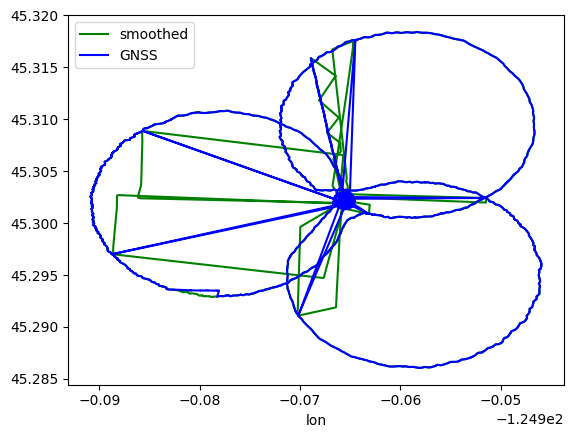

In [67]:
fig, ax = plt.subplots()
smoothed_results.plot("lon", "lat", ax=ax, c="green", label="smoothed")
compare = merged_df[0 : len(smoothed_results)][
    ~merged_df[0 : len(smoothed_results)].z.isnull()
]
compare.reset_index(drop=True, inplace=True)
lats, lons, alts = pymap3d.ecef2geodetic(
    compare.x.values, compare.y.values, compare.z.values
)
compare["lat"] = lats
compare["lon"] = lons
compare["hae"] = alts
compare.plot("lon", "lat", ax=ax, c="blue", label="GNSS")
plt.show()

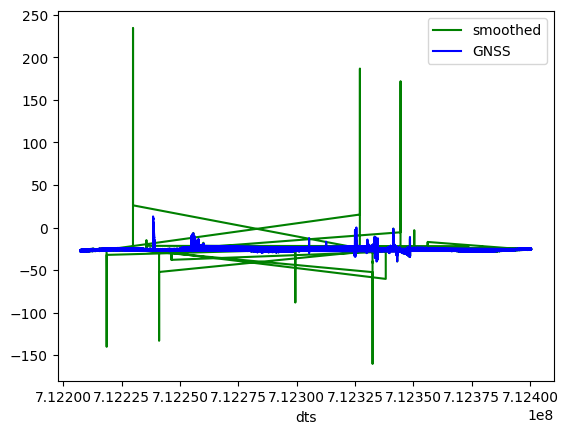

In [68]:
fig, ax = plt.subplots()
smoothed_results.plot("dts", "hae", ax=ax, c="green", label="smoothed")
compare = merged_df[0 : len(smoothed_results)][
    ~merged_df[0 : len(smoothed_results)].z.isnull()
]
compare.reset_index(drop=True, inplace=True)
lats, lons, alts = pymap3d.ecef2geodetic(
    compare.x.values, compare.y.values, compare.z.values
)
compare["lat"] = lats
compare["lon"] = lons
compare["hae"] = alts
compare.plot("dts", "hae", ax=ax, c="blue", label="GNSS")
plt.show()